In [32]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_hubble_parameter(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter as a function of redshift.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z, Hs, label=f'Hubble Parameter ({model_name} Model)', color='blue', linewidth=2)

    # Enhancements
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    plt.title('Hubble Parameter vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Optional: log scale for better visualization
    plt.xscale('log')  # Optional: log scale for better visualization
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


def plot_hubble_parameter_subplots(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter and the integrand 1/(H(z)*(1+z)) as subplots.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    # Calculate the integrand
    integrand = 1 / (Hs * (1 + z))

    # Create a DataFrame for Seaborn
    data = pd.DataFrame({'Redshift (z)': z, 'Hubble Parameter (H(z))': Hs, 'Integrand': integrand})

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Hubble parameter
    sns.lineplot(ax=axes[0], data=data, x='Redshift (z)', y='Hubble Parameter (H(z))', label=f'Hubble Parameter ({model_name} Model)', color='blue')
    axes[0].set_xlabel('Redshift (z)', fontsize=14)
    axes[0].set_ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    axes[0].set_title('Hubble Parameter vs Redshift', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].set_yscale('log')  # Optional: log scale for better visualization
    axes[0].set_xscale('log')  # Optional: log scale for better visualization
    axes[0].minorticks_on()
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=10)

    # Plot integrand
    sns.lineplot(ax=axes[1], data=data, x='Redshift (z)', y='Integrand', label='Integrand 1/(H(z)*(1+z))', color='green')
    axes[1].set_xlabel('Redshift (z)', fontsize=14)
    axes[1].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=14)
    axes[1].set_title('Integrand vs Redshift', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_yscale('log')  # Optional: log scale for better visualization
    axes[1].set_xscale('log')  # Optional: log scale for better visualization
    axes[1].minorticks_on()
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()
    plt.show()


In [3]:
#GILA model
def F_H(H, params, model):     
    lamb, L, beta, L_bar, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        FH = H**2 - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**(2*s)) \
                  #+ H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2)
    elif model == 'BETA':
        FH = H**2 - H**2            * beta * np.exp(-beta*(L_bar*H)**(2*s)) \
                  #+ H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4)

    return FH

def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, s = params # L and L_bar have to be in units of H0^{-1}

    if model == 'GILA':
        aux = np.exp(-beta*(L_bar*H)**(2*s)) * beta * (L_bar*H)**4 * (-3 + s * beta * (L_bar*H)**(2*s))
              #np.exp(lamb*(L*H)**2)       * lamb * (L*H)**6     * (4 + lamb*(L*H)**2)
    if model == 'BETA':
        aux = np.exp(-beta*(L_bar*H)**(2*s)) * beta                * (-1 + s * beta * (L_bar*H)**(2*s))
              #2 * np.exp(lamb*(L*H)**4)      * lamb * (L*H)**6  * (2 + lamb*(L*H)**4)

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, s],model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [4]:
def omega_CDM_to_luisa(beta, L_bar, H0, Omega_lcdm, s, model):
    factor_inv = H0**2 / F_H(H0, [LAMBDA, L/H0, beta, L_bar/H0, s], model) 
    omega_luisa = Omega_lcdm * factor_inv
    return omega_luisa

def params_to_chi2(theta, dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5), model='GILA'):


    chi2_SN = 0
    [Mabs, L_bar, b, H_0, s] = theta
    physical_params = [L_bar, b, H_0, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN

def log_likelihood(*args, **kargs):  
    '''
    Return the log likelihood in terms of the chi square.
    '''
    return -0.5 * params_to_chi2(*args, **kargs)


path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_pantheon_plus_shoes

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')

dof = ds_SN_plus_shoes[2].shape[0]-3


In [25]:
#Fix params
omega_r = 2.47e-5 
L_bar = 0.90
M_abs = -19.3
s = 4

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

z = np.linspace(0, 1000, int(10e3))
aou_threshold = 12.7


[69 70 71 72 73 74 75 76 77 78 79 80] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4]


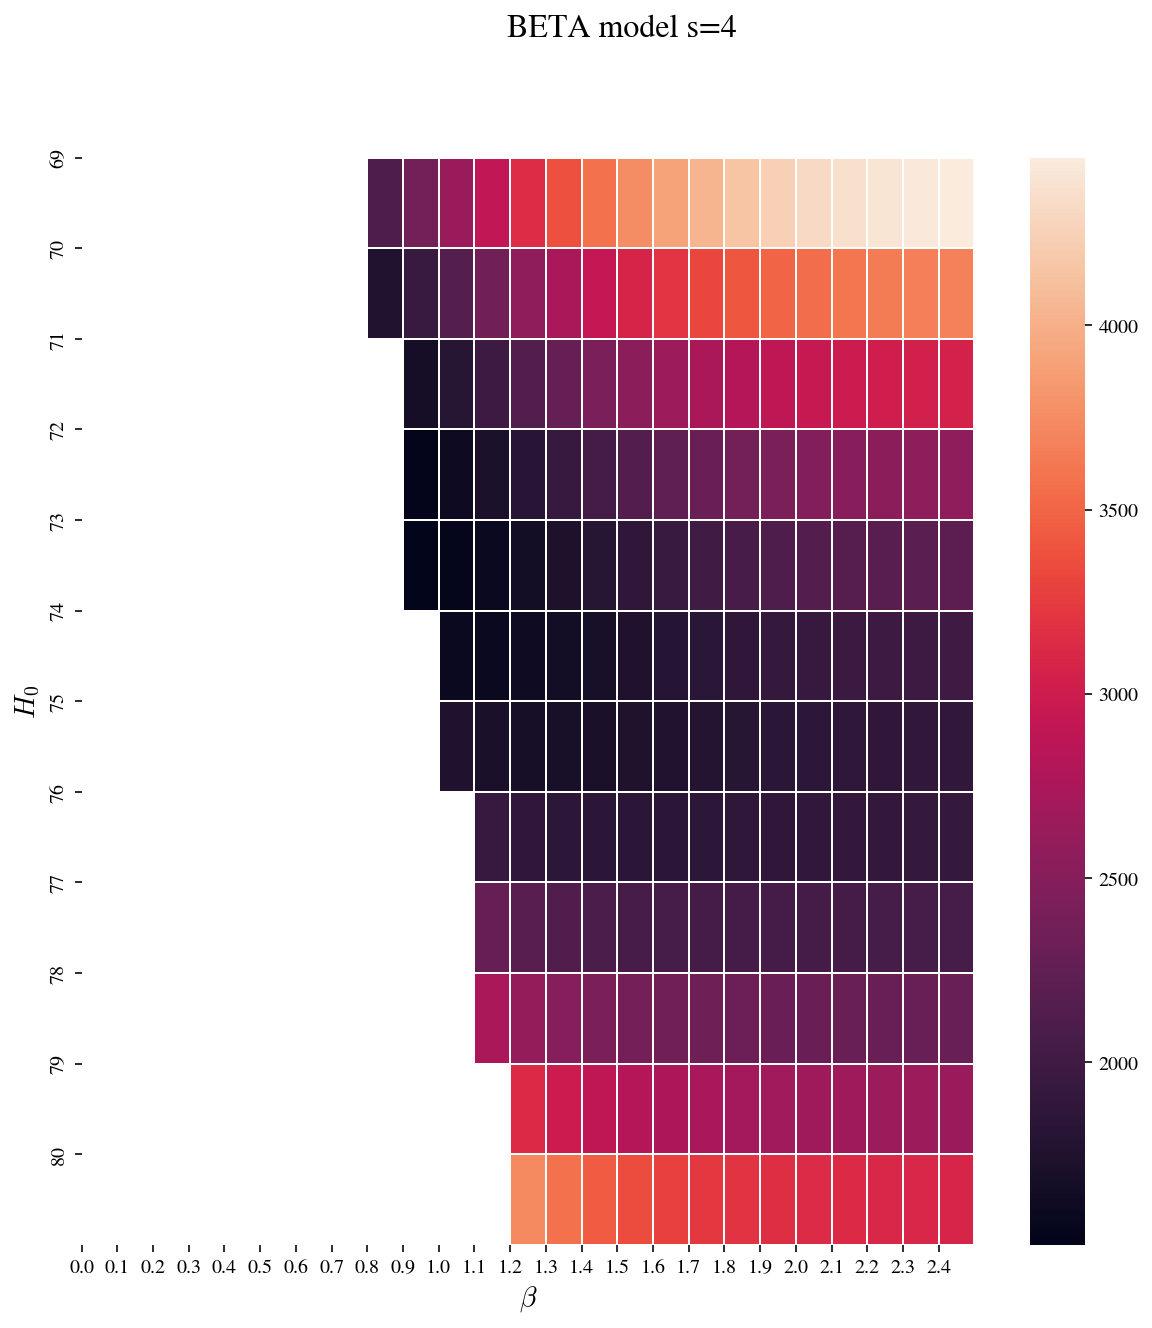

In [26]:
#BETA MODEL

H0_values = np.arange(69,81)
beta_values = np.linspace(0,2.5,10)
print(H0_values, beta_values)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('BETA model s={}'.format(s), fontsize=16) 

matrix_beta = np.zeros((len(H0_values), len(beta_values)))

for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='BETA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_beta[i, j] = np.nan
            continue
        aou_beta = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_beta < aou_threshold:
            matrix_beta[i, j] = np.nan
        else:
            theta = [M_abs, L_bar, beta_val, H0_val, s]
            chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='BETA')#/dof
            matrix_beta[i, j] = chi2
# Plot the heatmap with discrete colormap
ax = sns.heatmap(matrix_beta, linewidth=0.5)
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel(r'$H_0$', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(H0_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(H0_values)
ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_BETA_s={:3g}.png'.format(s)))
plt.show()

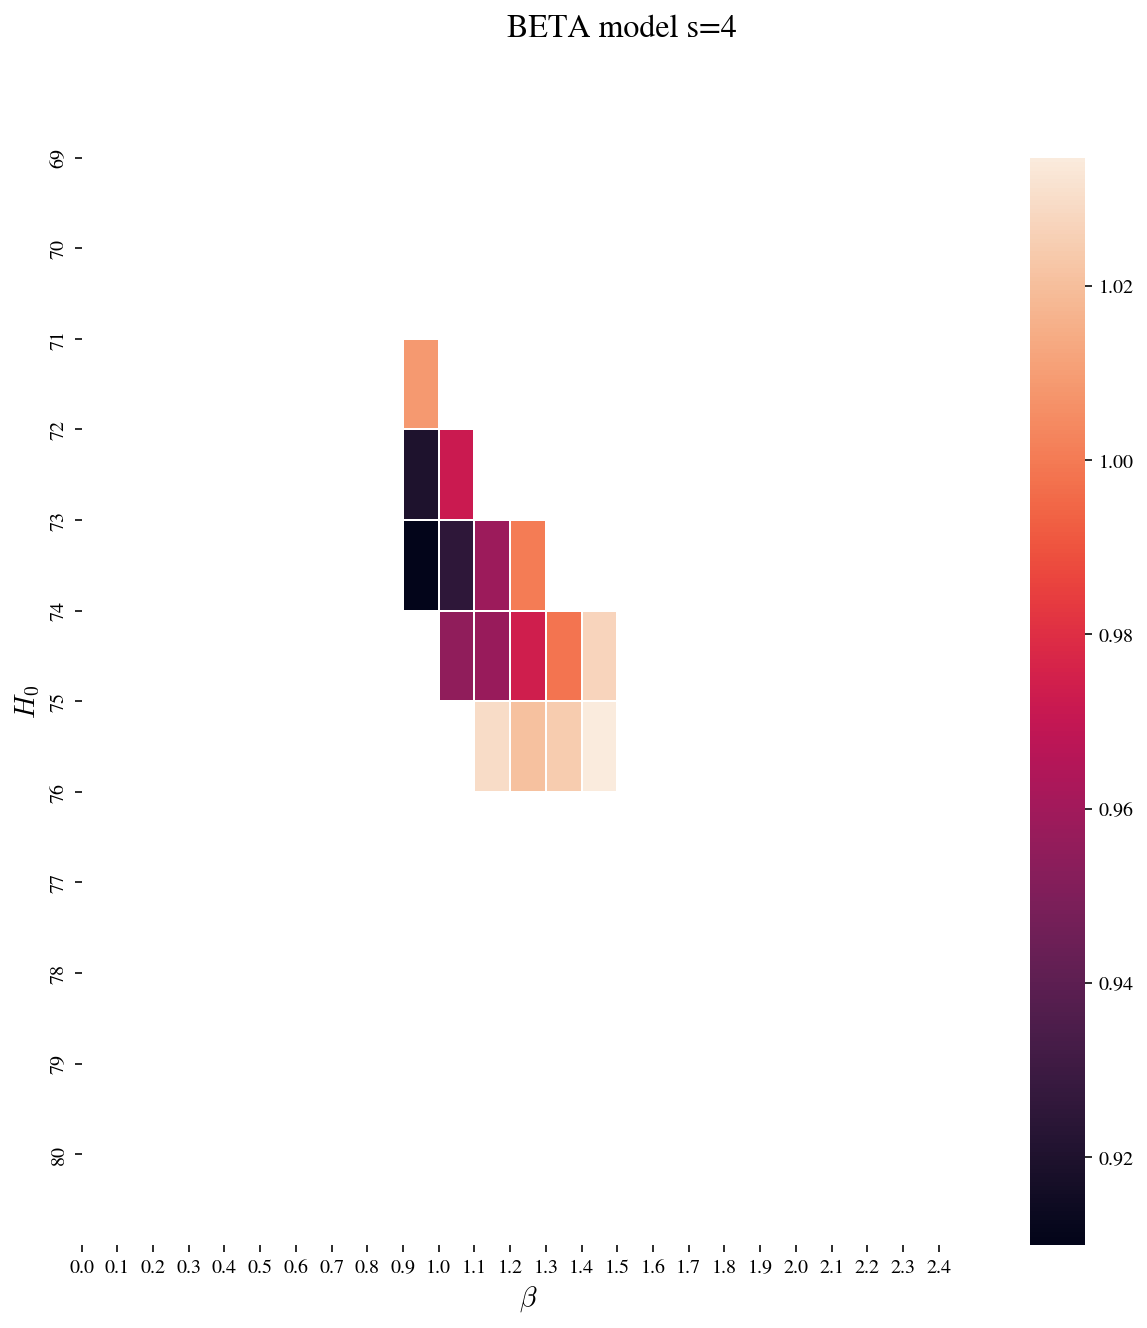

In [27]:

masked_arr = np.where(matrix_beta > dof +np.sqrt(2*dof), np.nan, matrix_beta)
# Plot the heatmap with discrete colormap
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('BETA model s={}'.format(s), fontsize=16) 
ax = sns.heatmap(masked_arr/dof, linewidth=0.5)
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel(r'$H_0$', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(H0_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(H0_values)
ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_BETA_s={:3g}_1.png'.format(s)))
plt.show()


[71.         71.66666667 72.33333333 73.         73.66666667 74.33333333
 75.         75.66666667 76.33333333 77.        ] [0.8        0.87777778 0.95555556 1.03333333 1.11111111 1.18888889
 1.26666667 1.34444444 1.42222222 1.5       ]


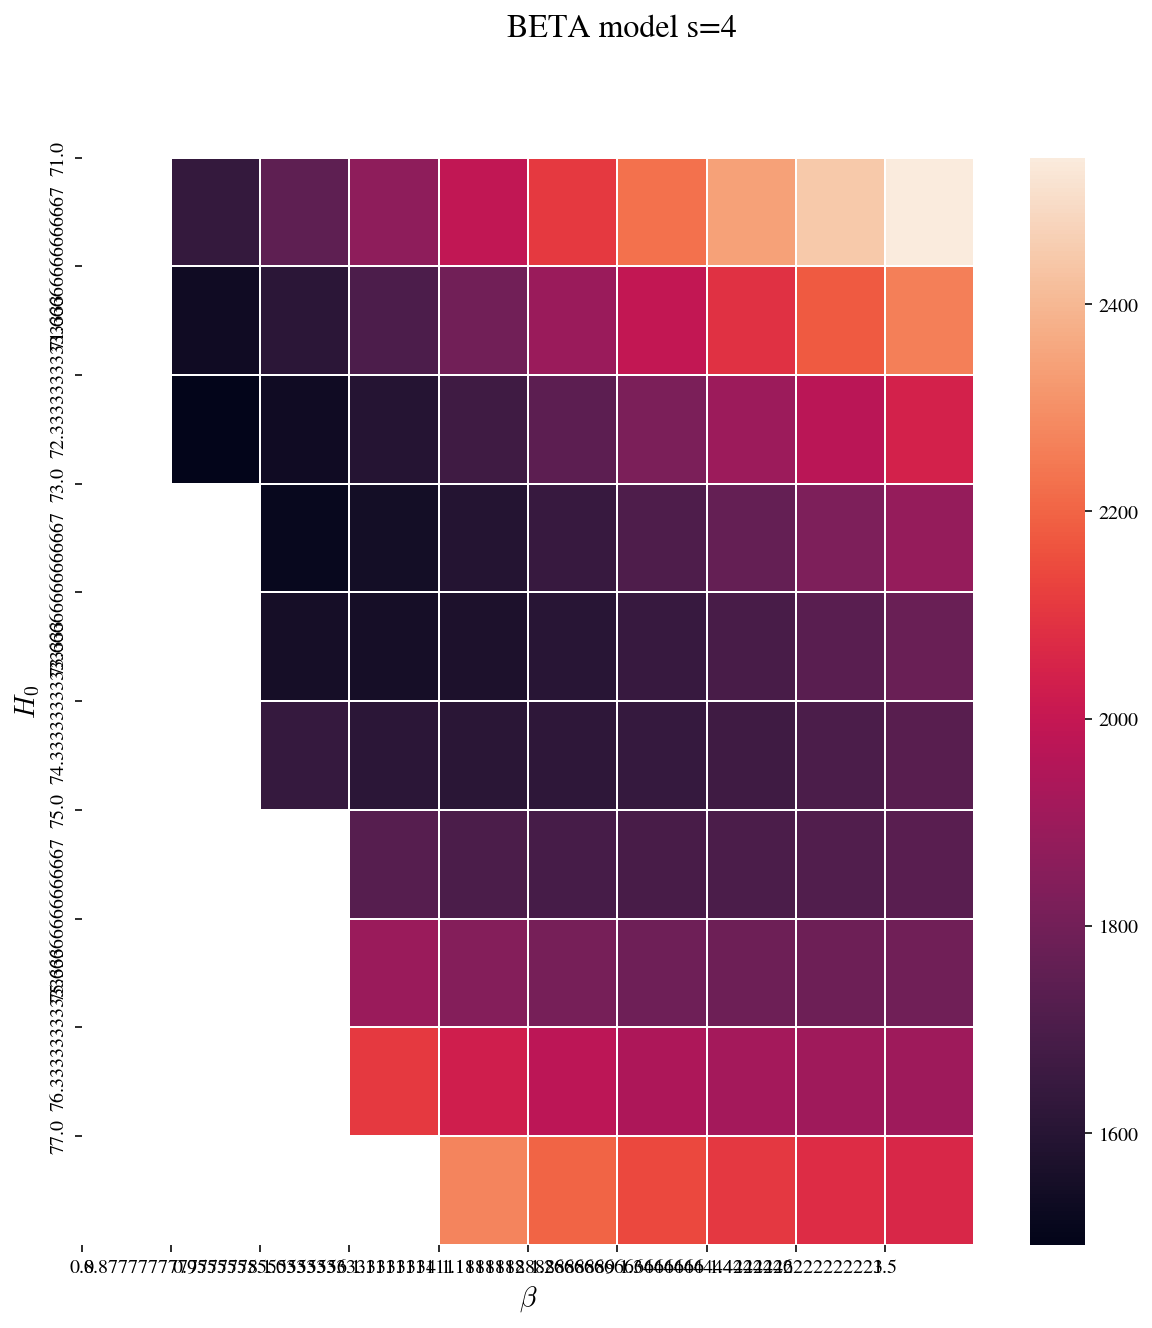

In [35]:
#BETA MODEL
H0_values = np.linspace(71,77,10)
beta_values = np.linspace(0.8,1.5,10)
print(H0_values, beta_values)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('BETA model s={}'.format(s), fontsize=16) 

matrix_beta = np.zeros((len(H0_values), len(beta_values)))

for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='BETA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_beta[i, j] = np.nan
            continue
        aou_beta = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_beta < aou_threshold:
            matrix_beta[i, j] = np.nan
        else:
            theta = [M_abs, L_bar, beta_val, H0_val, s]
            chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='BETA')#/dof
            matrix_beta[i, j] = chi2
# Plot the heatmap with discrete colormap
ax = sns.heatmap(matrix_beta, linewidth=0.5)
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel(r'$H_0$', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(H0_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(H0_values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.label_outer()
#fig.savefig(os.path.join(path_figures, 'heat_map_aou_BETA_s={:3g}.png'.format(s)))
plt.show()

[69 70 71 72 73 74 75 76 77 78 79 80] [0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6
 2.7 2.8 2.9]


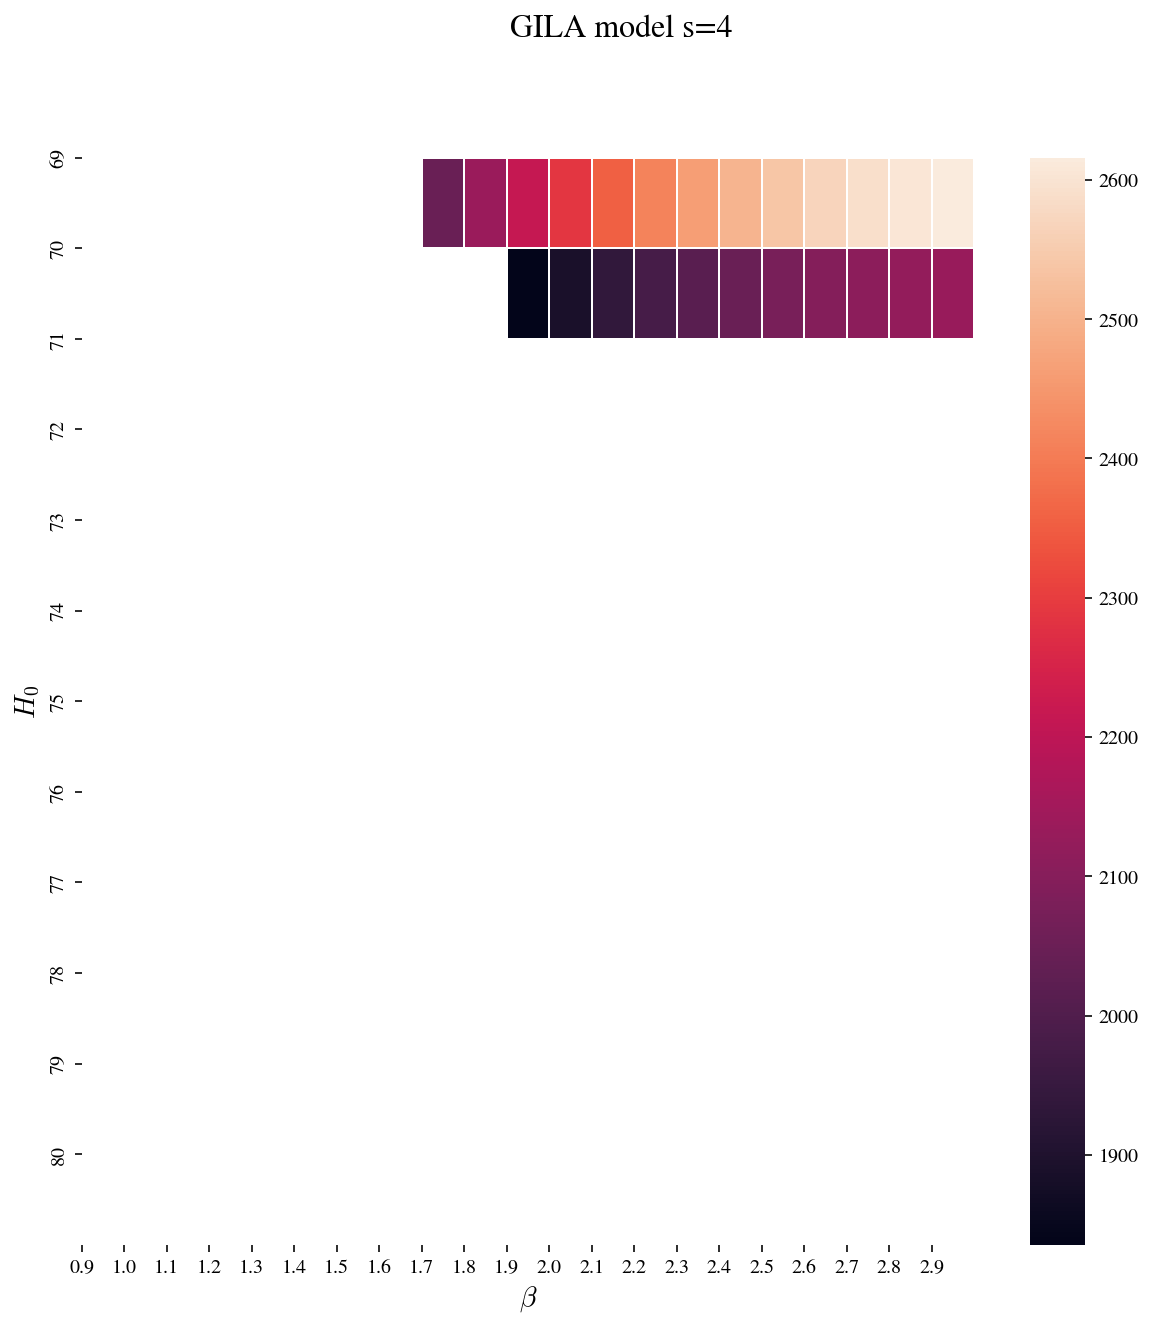

In [28]:
#GILA MODEL

H0_values = np.arange(69,81)
beta_values = np.arange(9,30,1)/10
print(H0_values, beta_values)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('GILA model s={}'.format(s), fontsize=16) 

matrix_gila = np.zeros((len(H0_values), len(beta_values)))

for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_gila[i, j] = np.nan 
            continue
        aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_gila < aou_threshold:
            matrix_gila[i, j] = np.nan 
        else:
            theta = [M_abs, L_bar, beta_val, H0_val, s]
            chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='GILA')#/dof
            matrix_gila[i, j] = chi2

# Plot the heatmap with discrete colormap
ax = sns.heatmap(matrix_gila, linewidth=0.5)
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel(r'$H_0$', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(H0_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(H0_values)
ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_s={:3g}.png'.format(s)))
plt.show()

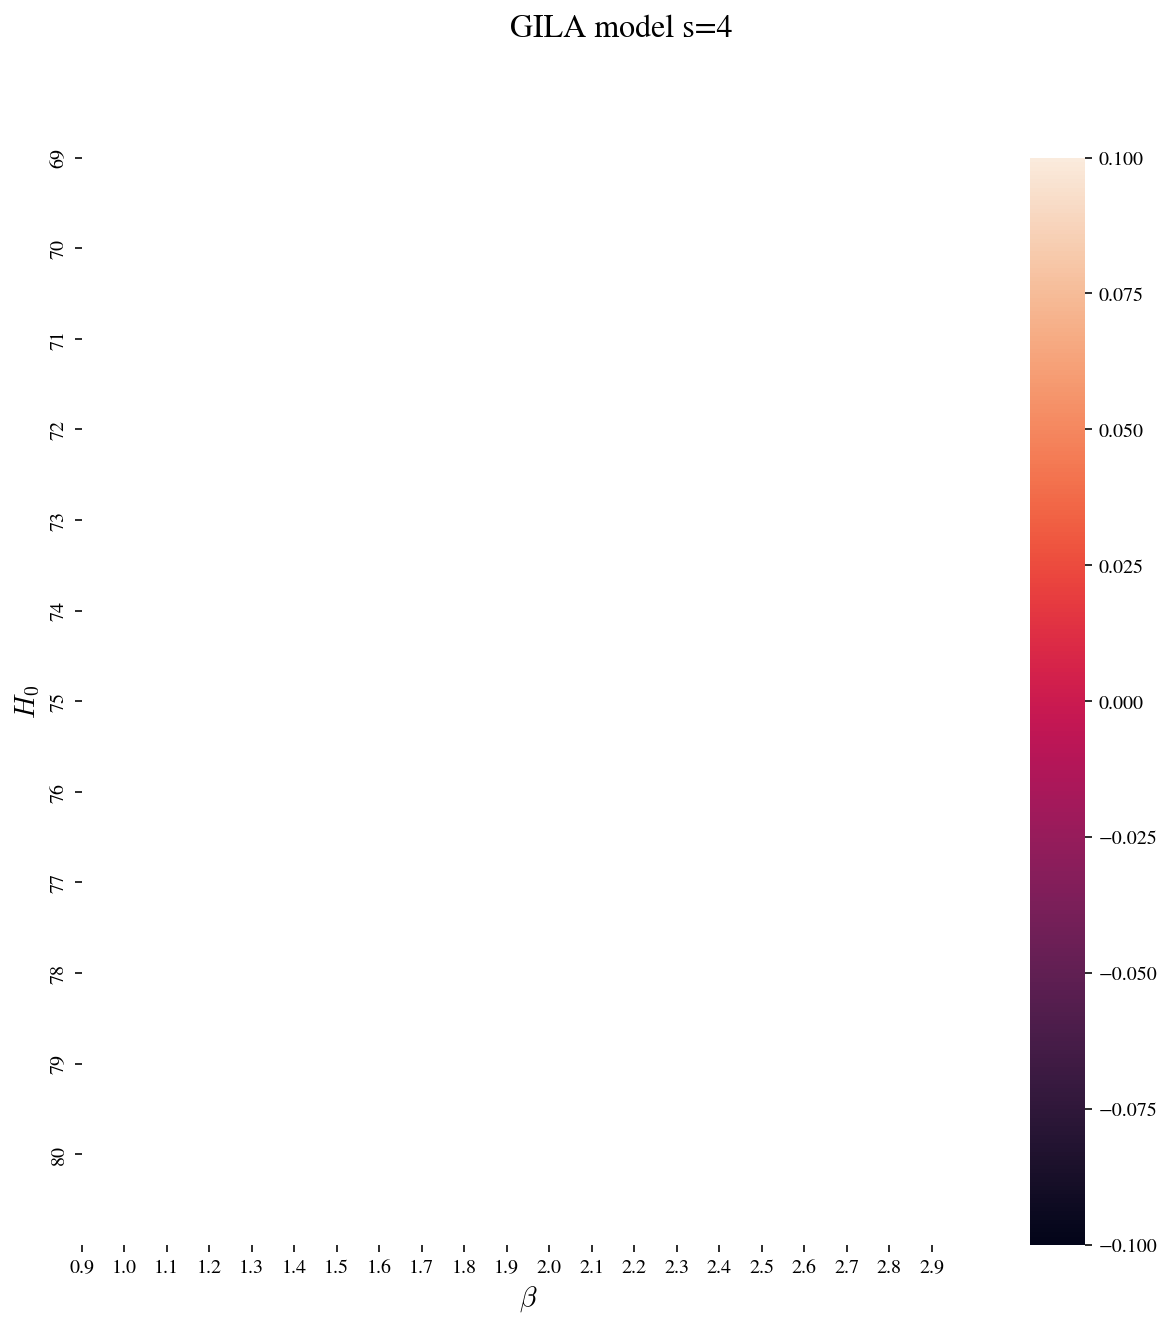

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('GILA model s={}'.format(s), fontsize=16) 
masked_arr = np.where(matrix_gila > dof +np.sqrt(2*dof), np.nan, matrix_gila)
# Plot the heatmap with discrete colormap
ax = sns.heatmap(masked_arr/dof, linewidth=0.5)
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel(r'$H_0$', fontsize=14)
ax.set_xticks(np.arange(len(beta_values)))
ax.set_yticks(np.arange(len(H0_values)))
ax.set_xticklabels(beta_values)
ax.set_yticklabels(H0_values)
ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_s={:3g}_1.png'.format(s)))
plt.show()
